In [1]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyccl as ccl
import sacc2
import sys
import datetime

In [3]:
nbin = 4

In [4]:
window_ranges = [
    [5,10],
    [10,20],
    [20,30],
    [30,40],
    [40,50],
    [50, 100],
    [100, 150],
    [150, 200],
    [250, 300],
    [350, 400],
    [400, 800],
    [800, 1200],
    [1200, 1500],
    [1500, 1800],
    [1800, 2000],
    [2000, 2500],
    [2500, 3000],
]
effective_ell = [0.5*(m+M) for m,M in window_ranges]

ell_max = window_ranges[-1][-1]

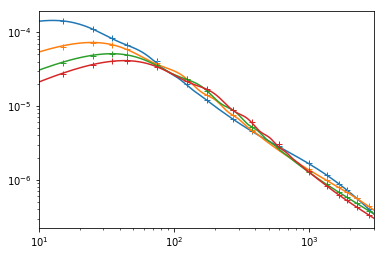

In [5]:
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.72, n_s=0.96, A_s=2.1e-9)
N_z = []
spectra = []
z = np.arange(0., 3.0, 0.01)
for i in range(nbin):
    mean_z = 0.3*(1+i)
    sigma_z = 0.05
    n_z = np.exp(-0.5*(z - mean_z)**2 / sigma_z**2)
    N_z.append(n_z)
    
    bias = np.ones_like(z) * 1.5*(mean_z/0.3)**0.5
    T = ccl.NumberCountsTracer(cosmo, False, (z,N_z[i]), (z, bias))
    ell = np.arange(ell_max+1)
    cl = ccl.angular_cl(cosmo, T, T, ell)
    cb = []
    for m,M in window_ranges:
        cb.append(np.mean(cl[m:M]))
    spectra.append(cb)
    line, = loglog(ell, cl)
    loglog(effective_ell, cb, '+', color=line.get_color())
    xlim(10,3000)
    
    

In [6]:
S = sacc2.Sacc()

S.metadata['nbin_lens'] = 4
S.metadata['nbin_source'] = 0 
S.metadata['creator'] = 'Beloved User'
S.metadata['creation'] = datetime.datetime.now().isoformat()
S.metadata['info'] = 'Theory predictions using CCL'

# In this case we use the same top-hat window for each bin.
# In reality we would probably use a different window for each
# pair of bins, empirically determined.
windows = [sacc2.TopHatWindow(m,M) for m,M in window_ranges]

for i in range(nbin):
    # Add the appropriate tracer
    S.add_tracer('NZ', f'bin_{i}', z, N_z[i])
    # Get the binned spectrum values
    cb = spectra[i]
    # In this case we are just doing LSS, so
    # there is just a single bin, repeated.
    bin_name = f'bin_{i}'
    # Add the values
    S.add_ell_cl('galaxy_density_cl', bin_name, bin_name, effective_ell, cb, window=windows)

In [7]:
S.save('sim.sacc', overwrite=True)

In [8]:
S2=sacc2.Sacc.load('sim.sacc')

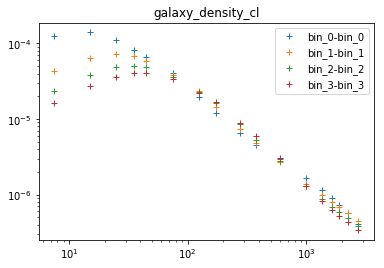

In [9]:
for dt in S2.get_data_types():
    figure()
    title(dt)
    for b1, b2 in S2.get_tracer_combinations(dt):
        ell, cb = S2.get_ell_cl(dt, b1, b1)
        loglog(ell, cb, '+', label=f'{b1}-{b2}')
    legend()

In [10]:
!cat sim.sacc

metadata: {creation: '2019-03-18T14:18:12.574709', creator: Beloved User, info: Theory
    predictions using CCL, nbin_lens: 4, nbin_source: 0}
tracers:
- name: bin_0
  nz: [1.5229979744712682e-08, 4.956405319172515e-08, 1.549753135702905e-07, 4.6557157157830946e-07,
    1.3438122776315214e-06, 3.7266531720786777e-06, 9.9295043058511e-06, 2.541934651619934e-05,
    6.252150377482048e-05, 0.00014774836023203415, 0.0003354626279025127, 0.0007318024188804734,
    0.0015338106793244659, 0.003088715408236777, 0.005976022895005958, 0.011108996538242316,
    0.019841094744370315, 0.03404745473459941, 0.05613476283413375, 0.08892161745938643,
    0.13533528323661287, 0.19789869908361474, 0.2780373004531943, 0.37531109885139985,
    0.48675225595997174, 0.6065306597126336, 0.7261490370736912, 0.8352702114112723,
    0.9231163463866361, 0.9801986733067553, 1.0, 0.9801986733067553, 0.9231163463866356,
    0.8352702114112718, 0.7261490370736906, 0.606530659712633, 0.48675225595997174,
    0.375311